## Kaggle房价预测

### 安装Kaggle

```bash
pip install kaggle --user
```

之后运行`kaggle -v`命令时，若是报错信息如下：

```python
Traceback (most recent call last):
  File "/home/hzq/.local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/home/hzq/.local/lib/python3.5/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/home/hzq/.local/lib/python3.5/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /home/hzq/.kaggle. Or use the environment method.
```

则需要到`kaggle`官网的`Account`目录下，里面有个`create new API Token`按钮，按下去会自动下载一个`kaggle.json`文件。

之后将下载好的`kaggle.json`文件放到刚刚报错的文件目录下面，也就是`/home/hzq/.kaggle`目录下。

### 下载数据集

```bash
kaggle competitions download -c house-prices-advanced-regression-techniques
```

### 解压数据集


```bash
unzip house-prices-advanced-regression-techniques.zip
```

## 处理数据

首先，我们将数据集读取进来，看一下其格式。

In [1]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("The Train Data Shape is : {}".format(train_data.shape))
print("The Test Daata Shape is : {}\n".format(test_data.shape))

The Train Data Shape is : (1460, 81)
The Test Daata Shape is : (1459, 80)



可以看到，训练数据集总共有1460个样本，每个样本的维度是81个维度，最后一个维度是标签。测试集有1459个样本，特征维度为80维。

查看一下训练数据集的前四行，的前四列和后四列

In [2]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


发现数据集中第一列尾id序号，我们并不需要这个特征。然后还有字符串，我们需要将其处理一下。首先将训练数据集的特征和测试数据集的特征拼接起来:

In [3]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

之后，将数值特征筛选出来:

In [4]:
numeric_features = all_features.dtypes[all_features.dtypes != "object"].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)

再处理字符串，调用pandas中的get_dummies()方法

In [5]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [6]:
all_features.shape  # 查看一下维度，发现它变成了331维。

(2919, 331)

处理完成之后，我们需要将训练集数据和测试集数据分开

In [7]:
import torch
n_train = train_data.shape[0]  # 训练集样本个数
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [8]:
print("train_data shape is {}".format(train_features.shape))
print("test_data shape is {}".format(test_features.shape))
print("train_data label shape is {}".format(train_labels.shape))

train_data shape is torch.Size([1460, 331])
test_data shape is torch.Size([1459, 331])
train_data label shape is torch.Size([1460, 1])


## 给定超参数

In [9]:
batch_size = 64
epochs = 500
learning_rate = 1

## 用DataSet封装数据

之后，我们用DataSet将数据封装一下:

In [10]:
import torch
import random
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [11]:
class Data(Dataset):
    def __init__(self, ):
        self.train_features = train_features
        self.train_labels = train_labels
    
    def __getitem__(self, index):
        return self.train_features[index], self.train_labels[index]
    
    def __len__(self):
        return len(self.train_labels)
training_data = Data()
train_dataloader = DataLoader(training_data, batch_size=batch_size)

## 构建模型

In [12]:
import torch.nn as nn
class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(input_dim, output_dim))
    def forward(self, x):
        return self.linear1(x)
model = MyNet(input_dim=train_features.shape[1], output_dim=1)

## 训练逻辑

### 网络训练逻辑

#### 设置优化器

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### 设置损失函数

之前，我们做误差是真实值减去预测值，但是这个对于房价来说并不是特别好，因为房价有可能卖一百万一套房，也有可能卖十万一套房。如果直接这么做的话，100万房价的误差可能会大一点，10万房子误差会小一点这样。

所以，采用相对误差来解决这个问题$\frac{y -\hat{y}}{y}$

In [14]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

但是优化的时候，依然采用均方差损失函数:

In [15]:
loss = nn.MSELoss()

In [16]:
def train_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    
    rmse_loss = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        # 计算前向传播和损失函数
        pred = model(X)
        l = loss_fn(pred, y)
        
        # 计算反向传播
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        rmse_loss += log_rmse(model, X, y)
    return rmse_loss

In [17]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    rmse_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            rmse_loss += log_rmse(model, X, y)
    return rmse_loss

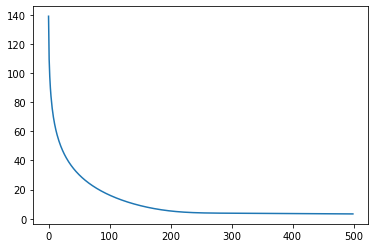

In [18]:
train_loss = []
for t in range(epochs):
    train_loss.append(train_loop(train_dataloader, model, loss_fn=loss))
    
import matplotlib.pyplot as plt
plt.plot(list(range(len(train_loss))), train_loss)
plt.show()

### K折交叉验证

In [19]:
def get_k_fold_data(k, i, X, y):
    assert k > 1  # 指定的 K 折交叉验证的 K 需要大于1。
    fold_size = X.shape[0] // k  # 总数据集大小除以k，得到每一折数据量应该是多大。
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  # 选中第j折
        X_part, y_part = X[idx, :], y[idx]
        if j == i:  # 如果第j折，是选定的第i折，那么就将其设置为验证集。
            X_valid, y_valid = X_part, y_part
        elif X_train is None:  # 如果 X_train 是第一次添加的话则直接赋值即可。
            X_train, y_train = X_part, y_part
        else:  # 如果 X_train 不是第一次添加的话则用cat与之前的数据集进行拼接即可。
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [20]:
def train_loop(dataloader, model, loss_fn):
    # 把优化器添加到train_loop中，来做k折交叉验证。
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    size = len(dataloader.dataset)
    
    rmse_loss = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        # 计算前向传播和损失函数
        pred = model(X)
        l = loss_fn(pred, y)
        
        # 计算反向传播
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        rmse_loss += log_rmse(model, X, y)
    return rmse_loss

In [21]:
def k_fold(k, x_train_data, y_train_data):
    train_loss_all, test_loss_all = [], []
    for i in range(k):
        # X_train, y_train, X_vaild, y_valid = get_k_fold_data(k, i, train_features, train_labels)
        X_train, y_train, X_vaild, y_valid = get_k_fold_data(k, i, x_train_data, y_train_data)
        # print(X_train.shape, y_train.shape)
        
        train_dataset = torch.utils.data.TensorDataset(x_train_data, y_train_data)
        traindata_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        test_dataset = torch.utils.data.TensorDataset(X_vaild, y_valid)
        testdata_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        model_new = MyNet(input_dim=train_features.shape[1], output_dim=1)
        
        for t in range(epochs):
            train_loss_all.append(train_loop(train_dataloader, model_new, loss_fn=loss))
            test_loss_all.append(test_loop(testdata_loader, model, loss_fn=loss))
    return train_loss_all, test_loss_all

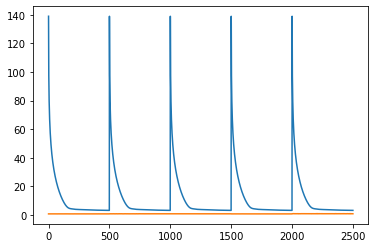

In [24]:
train_loss_all, test_loss_all = k_fold(k=5, x_train_data=train_features, y_train_data=train_labels)
import matplotlib.pyplot as plt
plt.plot(list(range(len(train_loss_all))), train_loss_all)
plt.plot(list(range(len(test_loss_all))), test_loss_all)
plt.show()

## 测试最终结果

In [25]:
preds = model(test_features).detach().numpy()
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)